In [ ]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt

Tensorflow version: 2.4.1


In [ ]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:, :, :4], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear  # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1)  # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)  # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1)  # shape = (batch, seq_len, 2)

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [ ]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

    #############################################################################


In [ ]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

            # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

    #############################################################################



In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config


In [ ]:
from datetime import datetime
df_bitcoin = pd.read_csv('/content/drive/MyDrive/DOGEUSDT.csv')
df_bitcoin = df_bitcoin.drop(columns=["Open","High","Low","Volume","Taker Buy Quote Asset Volume", "Taker Buy Base Asset Volume", "Quote Asset Volume", "Number of trades"])
df_bitcoin['Open timestamp'] = df_bitcoin['Open timestamp'].apply(lambda d: datetime.fromtimestamp(d))
# print(df_bitcoin['Open timestamp'].dt.year == 2019)
df_bitcoin = df_bitcoin[(df_bitcoin['Open timestamp'].dt.year == 2019) & (df_bitcoin['Open timestamp'].dt.minute == 0)]
df_bitcoin.index = df_bitcoin["Open timestamp"]
df_bitcoin = df_bitcoin.drop(columns=["Open timestamp"])
df_bitcoin.dropna(how='any', axis=0, inplace=True)
print(df_bitcoin.head())


                        Close
Open timestamp               
2019-07-05 12:00:00  0.004200
2019-07-05 13:00:00  0.003926
2019-07-05 14:00:00  0.003829
2019-07-05 15:00:00  0.003840
2019-07-05 16:00:00  0.003727


In [ ]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
dataset = df_bitcoin['Close'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)
trainset = dataset_list[:int(len(dataset_list) * (1 - test_percentage))]
testset = dataset_list[int(len(dataset_list) * (1 - test_percentage)):]

x_train = trainset[:, :-1]
y_train = trainset[:, -1:]
x_test = testset[:, :-1]
y_test = testset[:, -1:]

print('x_train.shape:' + str(x_train.shape))
print('y_train.shape:' + str(y_train.shape))
print('x_test.shape:' + str(x_test.shape))
print('y_test.shape' + str(y_test.shape))

x_train.shape:(3395, 50)
y_train.shape:(3395, 1)
x_test.shape:(849, 50)
y_test.shape(849, 1)


In [ ]:
batch_size = 256
seq_len = 50

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [ ]:
time_embedding_c = Time2Vector(seq_len)
attn_layer1_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer2_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer3_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

in_seq_c = Input(shape=(seq_len, 1))
x_c = time_embedding_c(in_seq_c)
x_c = Concatenate(axis=-1)([in_seq_c, x_c])
x_c = attn_layer1_c((x_c, x_c, x_c))
x_c = attn_layer2_c((x_c, x_c, x_c))
x_c = attn_layer3_c((x_c, x_c, x_c))
x_c = GlobalAveragePooling1D(data_format='channels_first')(x_c)
x_c = Dropout(0.1)(x_c)
x_c = Dense(64, activation='relu')(x_c)
x_c = Dropout(0.1)(x_c)
out_c = Dense(1, activation='linear')(x_c)

model = Model(inputs=[in_seq_c], outputs=[out_c])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])

model.load_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-2400')

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 50, 2)        200         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 50, 3)        0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 50, 3)        47890       concatenate[0][0]            

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)


Epoch 1/200
14/14 [==============================] - 86s 2s/step - loss: 7.2538e-04 - mae: 0.0201 - mape: 7.1781
Epoch 2/200
14/14 [==============================] - 34s 2s/step - loss: 7.8605e-04 - mae: 0.0211 - mape: 7.6061
Epoch 3/200
14/14 [==============================] - 34s 2s/step - loss: 8.1647e-04 - mae: 0.0212 - mape: 7.7103
Epoch 4/200
14/14 [==============================] - 34s 2s/step - loss: 7.6163e-04 - mae: 0.0203 - mape: 7.4165
Epoch 5/200
14/14 [==============================] - 34s 2s/step - loss: 7.3573e-04 - mae: 0.0198 - mape: 7.0765
Epoch 6/200
14/14 [==============================] - 34s 2s/step - loss: 7.2035e-04 - mae: 0.0200 - mape: 7.0960
Epoch 7/200
14/14 [==============================] - 34s 2s/step - loss: 7.2475e-04 - mae: 0.0200 - mape: 7.2372
Epoch 8/200
14/14 [==============================] - 34s 2s/step - loss: 7.4976e-04 - mae: 0.0202 - mape: 7.2544
Epoch 9/200
14/14 [==============================] - 34s 2s/step - loss: 6.8361e-04 - mae: 0.019

In [ ]:
# model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint')
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-600')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


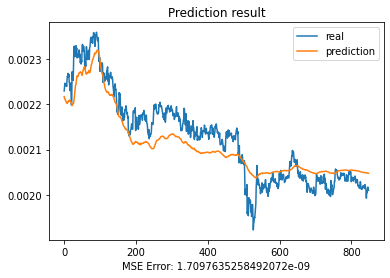

In [ ]:
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

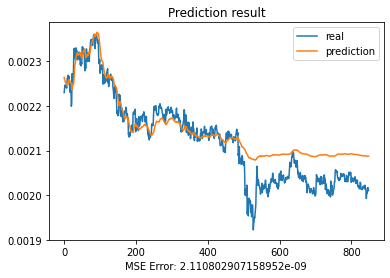

In [ ]:
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


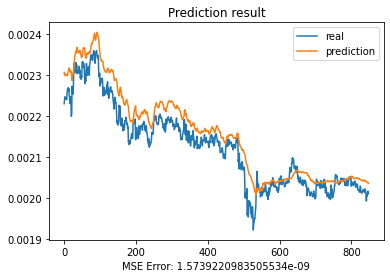

In [ ]:
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-600')

Epoch 1/200
14/14 [==============================] - 71s 3s/step - loss: 4.0973e-04 - mae: 0.0147 - mape: 5.3738
Epoch 2/200
14/14 [==============================] - 49s 3s/step - loss: 4.1026e-04 - mae: 0.0149 - mape: 5.4098
Epoch 3/200
14/14 [==============================] - 49s 3s/step - loss: 3.6287e-04 - mae: 0.0134 - mape: 4.8495
Epoch 4/200
14/14 [==============================] - 49s 4s/step - loss: 3.9986e-04 - mae: 0.0149 - mape: 5.4422
Epoch 5/200
14/14 [==============================] - 49s 3s/step - loss: 3.6153e-04 - mae: 0.0138 - mape: 5.1819
Epoch 6/200
14/14 [==============================] - 49s 3s/step - loss: 3.6424e-04 - mae: 0.0136 - mape: 5.0621
Epoch 7/200
14/14 [==============================] - 49s 3s/step - loss: 3.7803e-04 - mae: 0.0141 - mape: 4.9600
Epoch 8/200
14/14 [==============================] - 48s 3s/step - loss: 4.0886e-04 - mae: 0.0149 - mape: 5.4090
Epoch 9/200
14/14 [==============================] - 48s 3s/step - loss: 3.4772e-04 - mae: 0.013

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


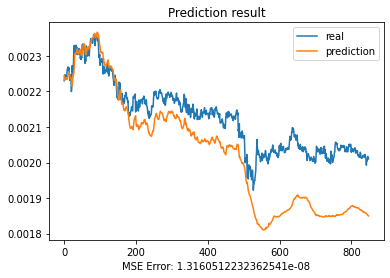

In [ ]:
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-800')

Epoch 1/200
14/14 [==============================] - 83s 4s/step - loss: 3.4917e-04 - mae: 0.0132 - mape: 5.0474
Epoch 2/200
14/14 [==============================] - 59s 4s/step - loss: 3.1983e-04 - mae: 0.0128 - mape: 5.0091
Epoch 3/200
14/14 [==============================] - 59s 4s/step - loss: 3.1544e-04 - mae: 0.0131 - mape: 4.9667
Epoch 4/200
14/14 [==============================] - 59s 4s/step - loss: 3.6097e-04 - mae: 0.0136 - mape: 5.2244
Epoch 5/200
14/14 [==============================] - 59s 4s/step - loss: 3.1013e-04 - mae: 0.0128 - mape: 4.7261
Epoch 6/200
14/14 [==============================] - 59s 4s/step - loss: 4.1760e-04 - mae: 0.0151 - mape: 5.6350
Epoch 7/200
14/14 [==============================] - 59s 4s/step - loss: 3.3496e-04 - mae: 0.0132 - mape: 4.9688
Epoch 8/200
14/14 [==============================] - 59s 4s/step - loss: 3.3888e-04 - mae: 0.0132 - mape: 5.1845
Epoch 9/200
14/14 [==============================] - 59s 4s/step - loss: 3.2810e-04 - mae: 0.012

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


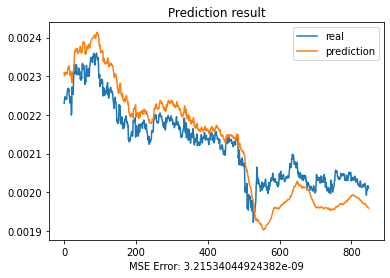

In [ ]:
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 90s 3s/step - loss: 2.5892e-04 - mae: 0.0118 - mape: 4.4370
Epoch 2/200
14/14 [==============================] - 38s 3s/step - loss: 3.0012e-04 - mae: 0.0123 - mape: 4.7041
Epoch 3/200
14/14 [==============================] - 38s 3s/step - loss: 2.9357e-04 - mae: 0.0124 - mape: 4.6645
Epoch 4/200
14/14 [==============================] - 38s 3s/step - loss: 2.9355e-04 - mae: 0.0124 - mape: 4.8015
Epoch 5/200
14/14 [==============================] - 38s 3s/step - loss: 2.8652e-04 - mae: 0.0123 - mape: 4.6249
Epoch 6/200
14/14 [==============================] - 38s 3s/step - loss: 2.9451e-04 - mae: 0.0124 - mape: 4.8729
Epoch 7/200
14/14 [==============================] - 38s 3s/step - loss: 2.9050e-04 - mae: 0.0122 - mape: 4.6090
Epoch 8/200
14/14 [==============================] - 38s 3s/step - loss: 3.0885e-04 - mae: 0.0120 - mape: 4.8723
Epoch 9/200
14/14 [==============================] - 38s 3s/step - loss: 3.0923e-04 - mae: 0.012

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


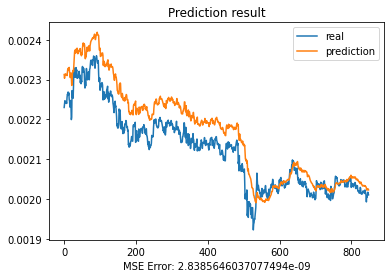

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-1000')
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 39s 3s/step - loss: 2.7360e-04 - mae: 0.0119 - mape: 4.4760
Epoch 2/200
14/14 [==============================] - 39s 3s/step - loss: 2.9252e-04 - mae: 0.0122 - mape: 4.6173
Epoch 3/200
14/14 [==============================] - 39s 3s/step - loss: 2.8097e-04 - mae: 0.0120 - mape: 4.5538
Epoch 4/200
14/14 [==============================] - 39s 3s/step - loss: 3.0728e-04 - mae: 0.0121 - mape: 4.5888
Epoch 5/200
14/14 [==============================] - 39s 3s/step - loss: 2.6805e-04 - mae: 0.0115 - mape: 4.2850
Epoch 6/200
14/14 [==============================] - 39s 3s/step - loss: 2.6975e-04 - mae: 0.0115 - mape: 4.3860
Epoch 7/200
14/14 [==============================] - 39s 3s/step - loss: 2.7764e-04 - mae: 0.0119 - mape: 4.4494
Epoch 8/200
14/14 [==============================] - 39s 3s/step - loss: 2.5809e-04 - mae: 0.0114 - mape: 4.2833
Epoch 9/200
14/14 [==============================] - 39s 3s/step - loss: 2.6293e-04 - mae: 0.011

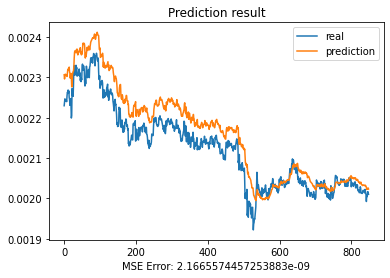

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-1200')
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 90s 5s/step - loss: 2.5148e-04 - mae: 0.0113 - mape: 4.2570
Epoch 2/200
14/14 [==============================] - 63s 4s/step - loss: 2.6976e-04 - mae: 0.0114 - mape: 4.2338
Epoch 3/200
14/14 [==============================] - 63s 5s/step - loss: 2.7031e-04 - mae: 0.0114 - mape: 4.3889
Epoch 4/200
14/14 [==============================] - 63s 4s/step - loss: 2.6874e-04 - mae: 0.0115 - mape: 4.2970
Epoch 5/200
14/14 [==============================] - 63s 4s/step - loss: 2.6727e-04 - mae: 0.0114 - mape: 4.1977
Epoch 6/200
14/14 [==============================] - 63s 4s/step - loss: 2.7525e-04 - mae: 0.0114 - mape: 4.4909
Epoch 7/200
14/14 [==============================] - 63s 4s/step - loss: 2.6312e-04 - mae: 0.0115 - mape: 4.3499
Epoch 8/200
14/14 [==============================] - 63s 4s/step - loss: 2.9241e-04 - mae: 0.0124 - mape: 4.7619
Epoch 9/200
14/14 [==============================] - 63s 4s/step - loss: 2.6512e-04 - mae: 0.011

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


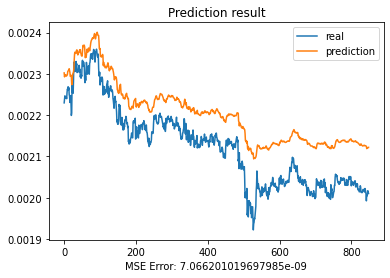

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-1400')
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 96s 5s/step - loss: 2.6549e-04 - mae: 0.0116 - mape: 4.4248
Epoch 2/200
14/14 [==============================] - 67s 5s/step - loss: 2.8091e-04 - mae: 0.0121 - mape: 4.5774
Epoch 3/200
14/14 [==============================] - 68s 5s/step - loss: 2.6035e-04 - mae: 0.0116 - mape: 4.3144
Epoch 4/200
14/14 [==============================] - 70s 5s/step - loss: 2.7136e-04 - mae: 0.0116 - mape: 4.4525
Epoch 5/200
14/14 [==============================] - 72s 5s/step - loss: 2.4038e-04 - mae: 0.0112 - mape: 4.2256
Epoch 6/200
14/14 [==============================] - 68s 5s/step - loss: 2.3067e-04 - mae: 0.0110 - mape: 4.1639
Epoch 7/200
14/14 [==============================] - 68s 5s/step - loss: 2.8440e-04 - mae: 0.0121 - mape: 4.6201
Epoch 8/200
14/14 [==============================] - 66s 5s/step - loss: 2.5635e-04 - mae: 0.0111 - mape: 4.1830
Epoch 9/200
14/14 [==============================] - 64s 5s/step - loss: 2.4849e-04 - mae: 0.011

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


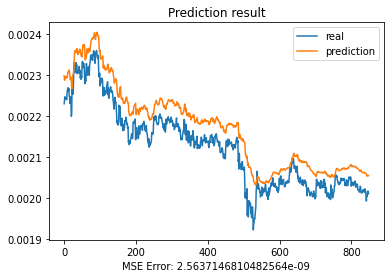

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-1600') #change model name HERE
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 88s 4s/step - loss: 2.4994e-04 - mae: 0.0111 - mape: 4.1671
Epoch 2/200
14/14 [==============================] - 62s 4s/step - loss: 2.3878e-04 - mae: 0.0107 - mape: 4.0557
Epoch 3/200
14/14 [==============================] - 62s 4s/step - loss: 2.2562e-04 - mae: 0.0110 - mape: 4.1232
Epoch 4/200
14/14 [==============================] - 62s 4s/step - loss: 2.7312e-04 - mae: 0.0116 - mape: 4.4455
Epoch 5/200
14/14 [==============================] - 62s 4s/step - loss: 2.5746e-04 - mae: 0.0113 - mape: 4.2304
Epoch 6/200
14/14 [==============================] - 62s 4s/step - loss: 2.3429e-04 - mae: 0.0109 - mape: 4.0288
Epoch 7/200
14/14 [==============================] - 62s 4s/step - loss: 2.5227e-04 - mae: 0.0115 - mape: 4.2249
Epoch 8/200
14/14 [==============================] - 62s 4s/step - loss: 2.3987e-04 - mae: 0.0110 - mape: 4.1609
Epoch 9/200
14/14 [==============================] - 62s 4s/step - loss: 2.2665e-04 - mae: 0.010

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


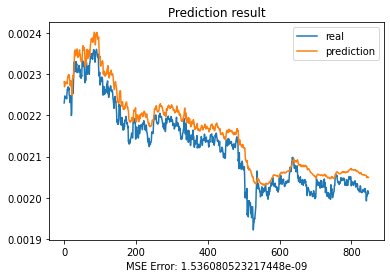

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-1800')
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 91s 5s/step - loss: 2.4974e-04 - mae: 0.0111 - mape: 4.1069
Epoch 2/200
14/14 [==============================] - 63s 4s/step - loss: 2.4407e-04 - mae: 0.0110 - mape: 4.1604
Epoch 3/200
14/14 [==============================] - 63s 5s/step - loss: 2.6906e-04 - mae: 0.0118 - mape: 4.4672
Epoch 4/200
14/14 [==============================] - 63s 5s/step - loss: 2.4119e-04 - mae: 0.0109 - mape: 4.0223
Epoch 5/200
14/14 [==============================] - 63s 4s/step - loss: 2.5212e-04 - mae: 0.0110 - mape: 4.1870
Epoch 6/200
14/14 [==============================] - 63s 5s/step - loss: 2.3646e-04 - mae: 0.0109 - mape: 4.1287
Epoch 7/200
14/14 [==============================] - 63s 5s/step - loss: 2.2778e-04 - mae: 0.0108 - mape: 3.9719
Epoch 8/200
14/14 [==============================] - 63s 4s/step - loss: 2.3931e-04 - mae: 0.0111 - mape: 4.1956
Epoch 9/200
14/14 [==============================] - 64s 5s/step - loss: 2.5389e-04 - mae: 0.011

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


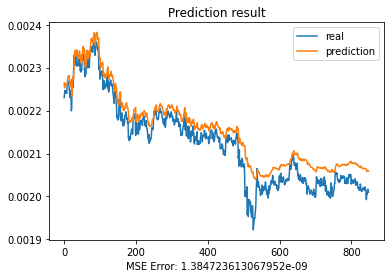

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-2000') #change here
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 93s 5s/step - loss: 2.2087e-04 - mae: 0.0106 - mape: 3.8896
Epoch 2/200
14/14 [==============================] - 64s 5s/step - loss: 2.3084e-04 - mae: 0.0109 - mape: 4.0090
Epoch 3/200
14/14 [==============================] - 64s 5s/step - loss: 2.3861e-04 - mae: 0.0110 - mape: 4.2087
Epoch 4/200
14/14 [==============================] - 65s 5s/step - loss: 2.3398e-04 - mae: 0.0108 - mape: 3.9241
Epoch 5/200
14/14 [==============================] - 64s 5s/step - loss: 2.3278e-04 - mae: 0.0107 - mape: 4.1187
Epoch 6/200
14/14 [==============================] - 64s 5s/step - loss: 2.5023e-04 - mae: 0.0112 - mape: 4.1231
Epoch 7/200
14/14 [==============================] - 64s 5s/step - loss: 2.3869e-04 - mae: 0.0110 - mape: 4.0564
Epoch 8/200
14/14 [==============================] - 64s 5s/step - loss: 2.2823e-04 - mae: 0.0108 - mape: 4.0974
Epoch 9/200
14/14 [==============================] - 64s 5s/step - loss: 2.4663e-04 - mae: 0.011

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


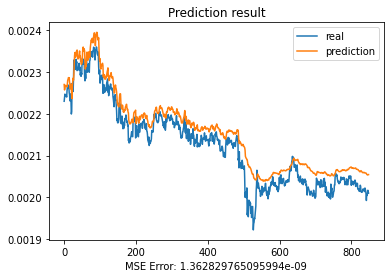

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-2200') #change here
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 78s 4s/step - loss: 2.3904e-04 - mae: 0.0110 - mape: 4.0581
Epoch 2/200
14/14 [==============================] - 55s 4s/step - loss: 2.2880e-04 - mae: 0.0107 - mape: 4.0171
Epoch 3/200
14/14 [==============================] - 54s 4s/step - loss: 2.3833e-04 - mae: 0.0107 - mape: 3.9143
Epoch 4/200
14/14 [==============================] - 54s 4s/step - loss: 2.4027e-04 - mae: 0.0108 - mape: 4.1599
Epoch 5/200
14/14 [==============================] - 55s 4s/step - loss: 2.2157e-04 - mae: 0.0107 - mape: 3.9235
Epoch 6/200
14/14 [==============================] - 54s 4s/step - loss: 2.2781e-04 - mae: 0.0105 - mape: 3.9208
Epoch 7/200
14/14 [==============================] - 54s 4s/step - loss: 2.3832e-04 - mae: 0.0107 - mape: 4.1071
Epoch 8/200
14/14 [==============================] - 55s 4s/step - loss: 2.1834e-04 - mae: 0.0106 - mape: 3.9291
Epoch 9/200
14/14 [==============================] - 55s 4s/step - loss: 2.4110e-04 - mae: 0.010

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


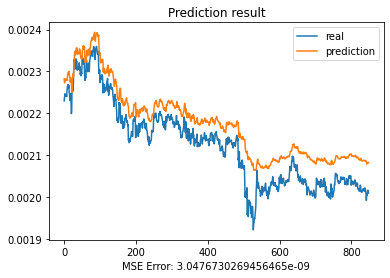

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-2400') #change here
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

In [ ]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)
model.save_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-2600') #change here
from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

Epoch 1/200
14/14 [==============================] - 79s 4s/step - loss: 2.4150e-04 - mae: 0.0110 - mape: 4.1123
Epoch 2/200
14/14 [==============================] - 55s 4s/step - loss: 2.1245e-04 - mae: 0.0103 - mape: 3.8161
Epoch 3/200
14/14 [==============================] - 55s 4s/step - loss: 2.3485e-04 - mae: 0.0108 - mape: 4.1126
Epoch 4/200
14/14 [==============================] - 55s 4s/step - loss: 2.3999e-04 - mae: 0.0109 - mape: 4.0777
Epoch 5/200
14/14 [==============================] - 55s 4s/step - loss: 2.8355e-04 - mae: 0.0118 - mape: 4.7077
Epoch 6/200
14/14 [==============================] - 55s 4s/step - loss: 2.3385e-04 - mae: 0.0110 - mape: 4.1594
Epoch 7/200
14/14 [==============================] - 55s 4s/step - loss: 2.4337e-04 - mae: 0.0114 - mape: 4.3738
Epoch 8/200
14/14 [==============================] - 55s 4s/step - loss: 2.2810e-04 - mae: 0.0105 - mape: 3.9674
Epoch 9/200
14/14 [==============================] - 55s 4s/step - loss: 2.3820e-04 - mae: 0.010

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


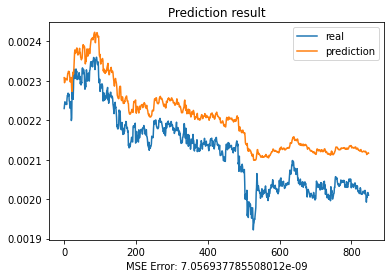

In [ ]:
time_embedding_c = Time2Vector(seq_len)
attn_layer1_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer2_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer3_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

in_seq_c = Input(shape=(seq_len, 1))
x_c = time_embedding_c(in_seq_c)
x_c = Concatenate(axis=-1)([in_seq_c, x_c])
x_c = attn_layer1_c((x_c, x_c, x_c))
x_c = attn_layer2_c((x_c, x_c, x_c))
x_c = attn_layer3_c((x_c, x_c, x_c))
x_c = GlobalAveragePooling1D(data_format='channels_first')(x_c)
x_c = Dropout(0.1)(x_c)
x_c = Dense(64, activation='relu')(x_c)
x_c = Dropout(0.1)(x_c)
out_c = Dense(1, activation='linear')(x_c)

model = Model(inputs=[in_seq_c], outputs=[out_c])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])

model.load_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-2600')

from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


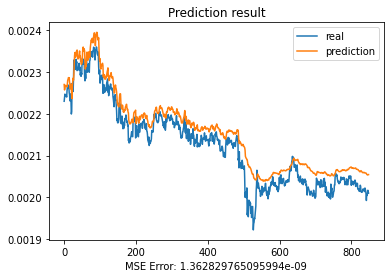

3.691652428244016e-05
1.362829765095994e-09
3.217312138011094e-05
0.8616955134586112
0.9846758582296214


In [ ]:
time_embedding_c = Time2Vector(seq_len)
attn_layer1_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer2_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer3_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

in_seq_c = Input(shape=(seq_len, 1))
x_c = time_embedding_c(in_seq_c)
x_c = Concatenate(axis=-1)([in_seq_c, x_c])
x_c = attn_layer1_c((x_c, x_c, x_c))
x_c = attn_layer2_c((x_c, x_c, x_c))
x_c = attn_layer3_c((x_c, x_c, x_c))
x_c = GlobalAveragePooling1D(data_format='channels_first')(x_c)
x_c = Dropout(0.1)(x_c)
x_c = Dense(64, activation='relu')(x_c)
x_c = Dropout(0.1)(x_c)
out_c = Dense(1, activation='linear')(x_c)

model = Model(inputs=[in_seq_c], outputs=[out_c])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])

model.load_weights('/content/drive/MyDrive/dogecoin/final_checkpoint-2200')

from sklearn.metrics.regression import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

rmse=np.sqrt(np.mean(((y_predict -y_real )**2)))
print(rmse)

print(mean_squared_error(y_real, y_predict))

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real, y_predict))

from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

acc = ((1 - np.mean(abs(y_real -y_predict)/y_real)))
# print(np.mean(abs(y_real -y_predict)/y_real))
print(acc)